In [1]:
# standard library
import os
from os import path
import sys
_path = path.abspath('../pkg/')
if _path not in sys.path:
    sys.path.append(_path)
import pickle

# Third-party
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import corner
from schwimmbad import MultiPool, SerialPool

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import UnitSystem

import emcee
from pyia import GaiaData

from chemtrails.potential import Sech2Potential, UniformPotential
from chemtrails.likelihood import Model
from chemtrails.data import load_nominal_galah, load_nominal_apogee, get_abundance_data

In [2]:
usys = UnitSystem(u.pc, u.Myr, u.Msun, u.radian, u.km/u.s)

# GALAH

In [3]:
teff_lim = [3500, 6000] * u.K
logg_lim = [-0.5, 3.5]
d_lim = 1.5 * u.kpc
vz_lim = 100 * u.km/u.s
snr_lim = 16

In [4]:
# g, galcen = load_nominal_galah('/Users/adrian/data/GaiaDR2/GALAH-GaiaDR2-xmatch.fits',
#                                zlim=1*u.kpc, vlim=100*u.km/u.s)

survey = 'galah'
g = GaiaData('/Users/adrian/data/GaiaDR2/GALAH-GaiaDR2-xmatch.fits')
g = g[g.parallax > 0.]

mask = np.isfinite(g.parallax_error)
mask &= (g.parallax / g.parallax_error) > 8
mask &= (g.teff > teff_lim[0]) & (g.teff < teff_lim[1])
mask &= (g.logg > logg_lim[0]) & (g.logg < logg_lim[1])

# make coordinates
c = g.get_skycoord(radial_velocity=g.rv_synt)
mask &= np.isfinite(g.parallax) & (g.distance < d_lim)

galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc))
mask &= np.abs(galcen.v_z) < vz_lim

mask &= (g.snr_c1 > snr_lim) & (g.snr_c2 > snr_lim) & (g.snr_c3 > snr_lim)

g = g[mask]
galcen = galcen[mask]
len(g)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


22794

### Quick model test:

In [5]:
model = Model(galcen, g, ['fe_h'], 
              frozen_pars=dict(sun_z=0., sun_vz=0.),
              marginalize='alpha', metals_deg=3)
model([np.log(65), np.log(250), np.log(0.25**2)])

-11165.674795417808

---

## Emcee

In [6]:
p0 = np.array([np.log(65), np.log(250), 2*np.log(0.2)])

nwalkers = 64
ndim = len(p0)
p0 = emcee.utils.sample_ball(p0, std=[1e-2, 1e-2, 1e-3], 
                             size=nwalkers)

In [7]:
elem = ['fe_h']

name = '_'.join(sorted(elem))

model = Model(galcen, g, elem,
              frozen_pars=dict(sun_z=0., sun_vz=0.),
              marginalize=True, metals_deg=3)

nburn = 1024
nsteps = 1024
with SerialPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model, 
                                    pool=pool)

    print("burn-in")
    pos, prob, state = sampler.run_mcmc(p0.copy(), nburn, progress=True)

    if nsteps > 0:
        print("sampling")
        sampler.reset()
        _ = sampler.run_mcmc(pos, nsteps, progress=True)

  0%|          | 2/1024 [00:00<00:54, 18.71it/s]

burn-in


  0%|          | 2/1024 [00:00<00:58, 17.59it/s]

sampling


100%|██████████| 1024/1024 [00:35<00:00, 28.68it/s]


In [8]:
np.median(sampler.acceptance_fraction)

0.5380859375

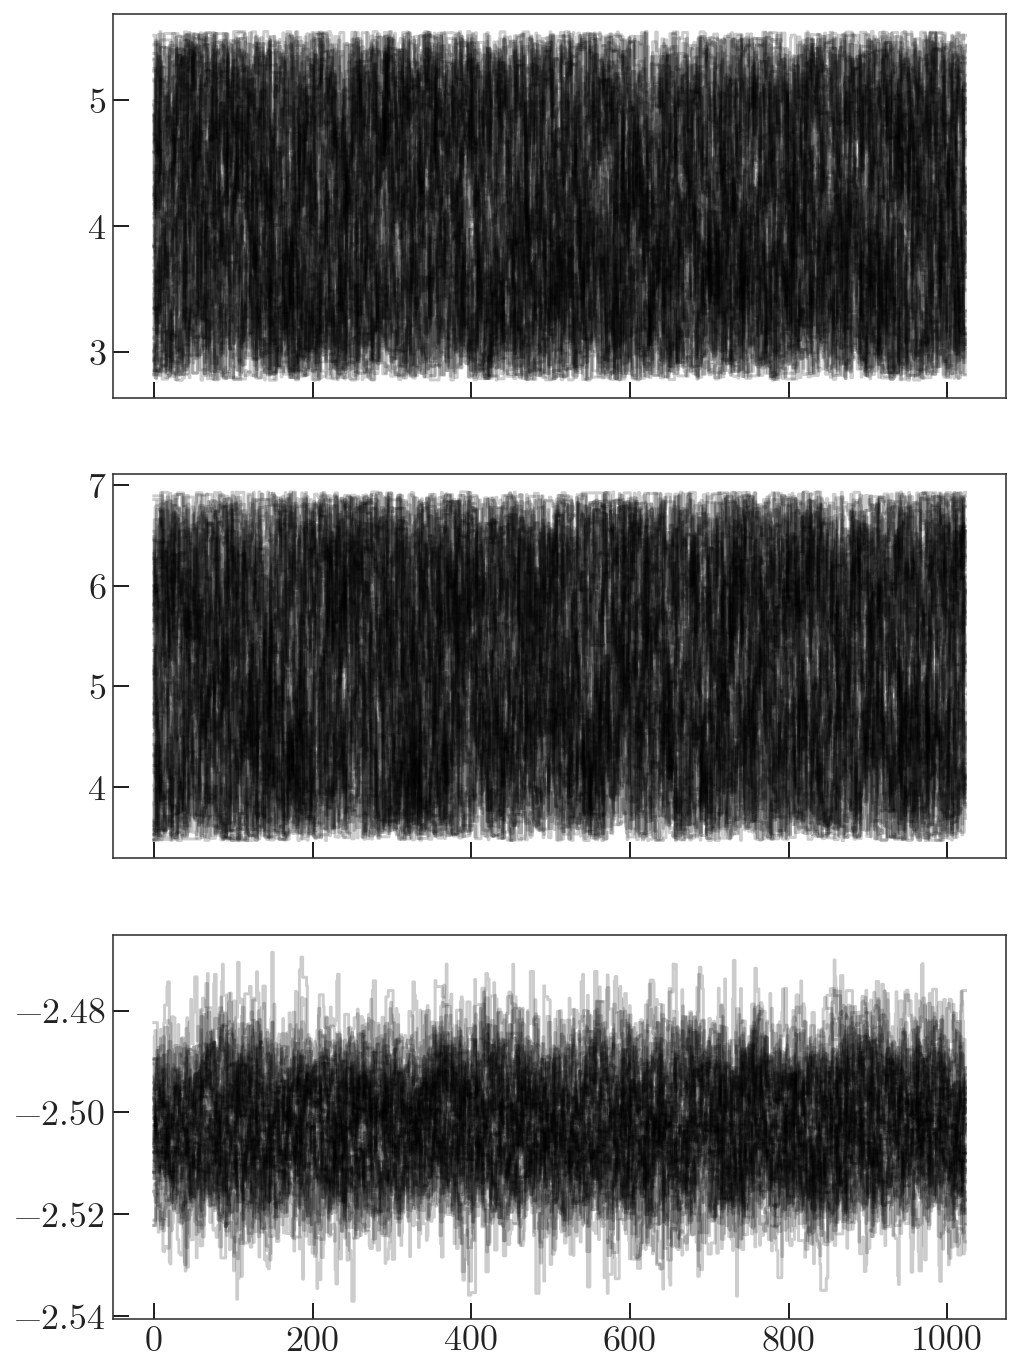

In [9]:
fig, axes = plt.subplots(ndim, 1, figsize=(8, 4*ndim),
                         sharex=True)
for k in range(ndim):
    ax = axes[k]
    for walker in sampler.chain[..., k]:
        ax.plot(walker, marker='', drawstyle='steps-mid', 
                color='k', alpha=0.2)

In [10]:
lnsigma, lnhz, *_ = np.mean(sampler.flatchain, axis=0)
np.exp(lnsigma), np.exp(lnhz)

(62.021482062119546, 179.13560719482774)

Text(0.5,0,'$\\Sigma$ [$\\mathrm{M_{\\odot}\\,pc^{-2}}$]')

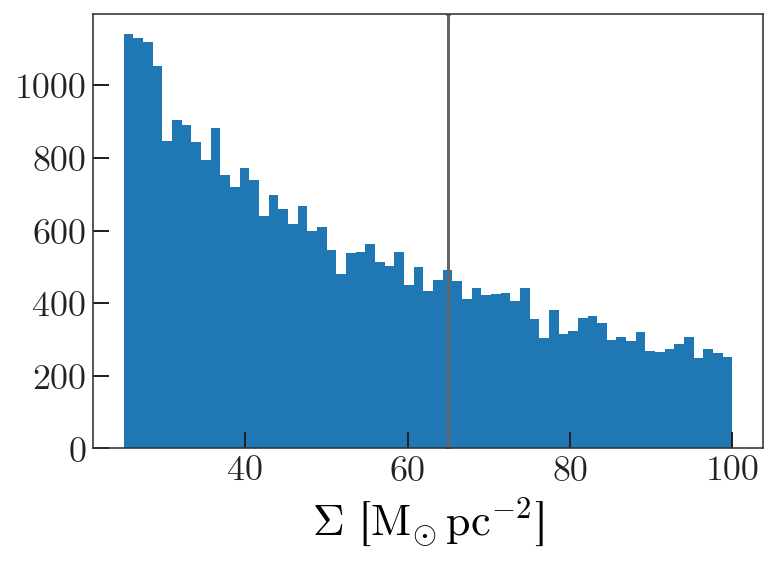

In [11]:
plt.hist(np.exp(sampler.flatchain[..., 0]), 
         bins=np.linspace(25, 100, 64));
plt.axvline(65.)
plt.xlabel(r'$\Sigma$ [{:latex_inline}]'.format(u.Msun/u.pc**2))